In [1]:
#! pip install --user scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Loading datasets

In [3]:
# Temperature, Precipitation, Potential Evaporation (PET)
Temp_RH_PET = pd.read_csv('Outputs/Temp_RH_PET.csv', index_col=['HYBAS_ID'])
#Temp_RH_PET.head()

In [4]:
# indices, soil parameters
params_ind_soil = pd.read_csv('Outputs/params_ind_soil.csv', index_col='HYBAS_ID')
del params_ind_soil['Unnamed: 0']
#params_ind_soil.head()

In [5]:
# land uses
land_uses = pd.read_csv('Outputs/land_uses_perc.csv', index_col=['HYBAS_ID'])
del land_uses['Unnamed: 0']
#land_uses.head()

In [6]:
# Shapes of dataframes
print('The shape of land_uses df is {0}'.format(land_uses.shape))
print('The shape of Temp_RH_PET df is {0}'.format(Temp_RH_PET.shape))
print('The shape of params_ind_soil df is {0}'.format(params_ind_soil.shape))

The shape of land_uses df is (28, 5)
The shape of Temp_RH_PET df is (24, 36)
The shape of params_ind_soil df is (27, 9)


In [7]:
# Merging the data
merge_1 = params_ind_soil.merge(land_uses, on='HYBAS_ID', how='inner')
merge_all = merge_1.merge(Temp_RH_PET, on='HYBAS_ID', how='inner')
merge_all.shape

(23, 50)

<AxesSubplot:>

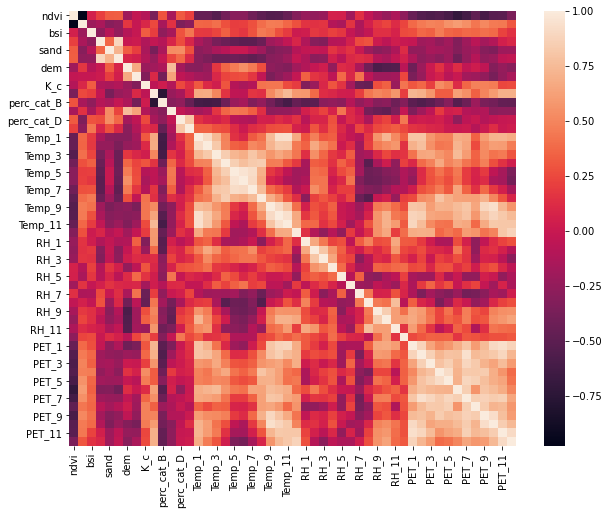

In [8]:
import seaborn as sns

# Correlation_matrix
corr  = merge_all.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, ax=ax)

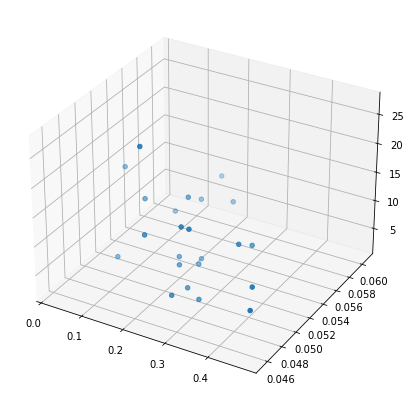

In [9]:
# 3-D plots are useful to provide deep insights about the data
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(merge_all.ndvi, merge_all.PET_2, merge_all.slope)
plt.show()

# Applying k-means (using 4 classes)

In [10]:
import sklearn
from sklearn.cluster import KMeans 

k_means = KMeans(init = "k-means++", n_clusters = 4, n_init = 12)
k_means.fit(merge_all.values)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers.shape

(4, 50)

# Plot of features in pairs

In [18]:
count =0 
import itertools
for subset in itertools.combinations(merge_all.columns, 2): count+=1 
print('The total number of possible combinations is {0}'.format(count))

The total number of possible combinations is 1225


Given that the total number of all possible combinations is 1225 based on the above mentioned code, only the combinations of the first feature with the rest were illustrated in the figure below. Even using one feature has created a packed plot.

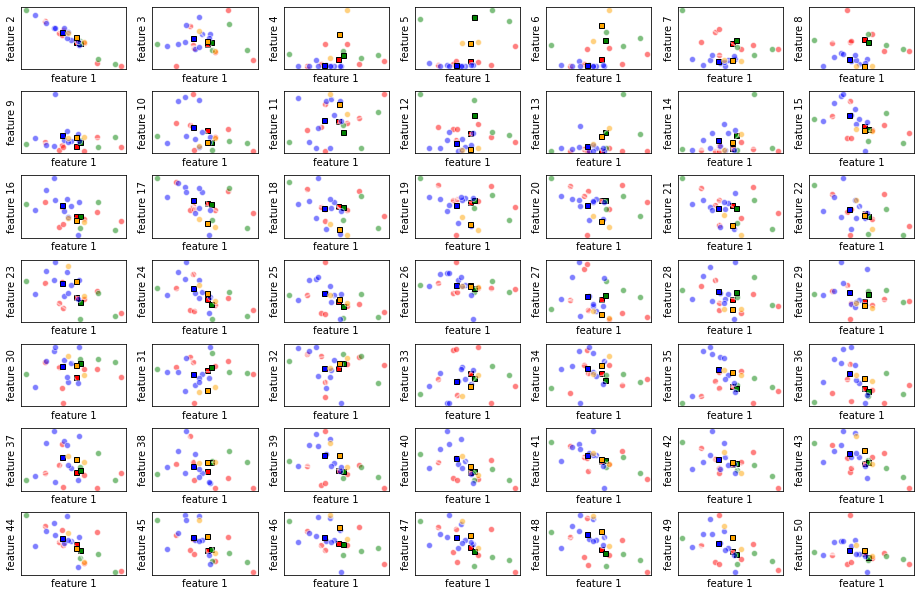

In [20]:
colors = ['red', 'green', 'blue', 'orange']
fig, axs = plt.subplots(8,7,figsize=(16,12))
axs = axs.ravel()
fig.subplots_adjust(hspace = .35, wspace=.25)

for j in range(1,50):
    for k in range(len(set(k_means_labels))):
        my_members = (k_means_labels == k)
        cluster_center = [k_means_cluster_centers[k, 0], k_means_cluster_centers[k, j]]
        axs[j-1].plot(merge_all.iloc[my_members, 0], merge_all.iloc[my_members, j], 'w',
                    markerfacecolor=colors[k], marker='o', alpha = 0.5)
        axs[j-1].set_xlabel('feature 1')
        axs[j-1].set_ylabel('feature '+str(j+1))
        axs[j-1].set_xticks(())
        axs[j-1].set_yticks(())
        axs[j-1].plot(k_means_cluster_centers[k, 0], k_means_cluster_centers[k, j], 's',
                    markerfacecolor=colors[k],  markeredgecolor='k', markersize=5)

for l in range(49,56):
    fig.delaxes(axs[l])

# Normalization

K-Means is a distance-based algorithm. Because of that, it’s important to normalize, standardize, or choose any other option in which the distance has some comparable meaning for all the columns. MinMaxScaler, it’s an excellent tool for it.

# Inertia

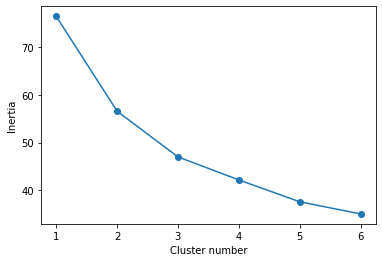

In [21]:
# Inertia was calculated to determine the most suitable number of clusters
from sklearn.preprocessing import MinMaxScaler

X=merge_all.reset_index(drop=True)
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)
inertia = []
for i in range(1,7):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(inertia, '-o')
ax.set_xlabel('Cluster number')
ax.set_ylabel('Inertia')
plt.xticks(np.arange(0,6), np.arange(1,7));
# the elbow shows up when number of clusters equals 3

# Applying k-means for n_clusters=4 having normalized the features first

In [24]:
kmeans_norm = KMeans(
        n_clusters=3, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )

kmeans_norm.fit(X)
clusters=pd.DataFrame(X,columns=merge_all.columns)
clusters['label']=kmeans.labels_
clusters

polar=clusters.groupby("label").mean().reset_index()
polar


,label,ndvi,ndwi,bsi,clay,sand,silt,dem,slope,K_c,...,PET_3,PET_4,PET_5,PET_6,PET_7,PET_8,PET_9,PET_10,PET_11,PET_12
0,0,0.548984,0.360110,0.730610,0.092137,0.519793,0.201622,0.395069,0.691107,0.030307,...,0.544464,0.449344,0.433183,0.416085,0.359438,0.420489,0.313406,0.292498,0.254028,0.213927
1,1,0.351709,0.638551,0.434208,0.048733,0.152001,0.101487,0.320258,0.203017,0.168043,...,0.596171,0.513911,0.617512,0.637836,0.609877,0.664518,0.612304,0.564957,0.476641,0.335471
2,2,0.304414,0.669068,0.725596,0.000000,0.000000,0.000000,0.196311,0.224848,1.000000,...,0.680574,1.000000,1.000000,0.656515,0.912692,0.971437,1.000000,1.000000,0.664557,0.553466
3,3,0.328773,0.617845,0.514319,0.127135,0.030514,0.102609,0.103979,0.260738,0.159406,...,0.749996,0.539213,0.659463,0.828061,0.812902,0.714120,0.719217,0.855571,0.831196,0.660773
4,4,0.710640,0.296407,0.288494,0.329675,0.422676,0.441956,0.257543,0.293582,0.169659,...,0.329758,0.276447,0.334488,0.114364,0.202267,0.438325,0.257456,0.261025,0.217770,0.231000
5,5,0.554092,0.383215,0.563389,0.001925,0.020860,0.006450,0.134921,0.123917,0.163283,...,0.000000,0.260355,0.171259,0.609317,0.146849,0.000000,0.490118,0.618065,0.000000,0.000000


In [ ]:
polar=pd.melt(polar,id_vars=["label"])
polar

In [ ]:
pie=clusters.groupby('label').size()

In [ ]:
plt.polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)

In [ ]:
plt.pie(clusters.label.value_counts(), labels=np.arange(0,3), shadow=True);

# <font color='blue'> Performance 

SOS - comparing kmeans resukts using normalized and not normalized features   

# Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient (sklearn.metrics.silhouette_score) is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

$$
s=\frac{b-a}{\max (a, b)}
$$

2.3.10.5. Silhouette Coefficient

In [ ]:
from sklearn import metrics
Silhouette_ar, calinski_ar, davies_ar = np.zeros(5), np.zeros(5), np.zeros(5)

# silhouette_score requires more than 1 cluster labels.
for i in range(2,7):
    kmeans = KMeans(
        n_clusters=i, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
    kmeans.fit(X)
    labels = kmeans.labels_
    Silhouette = metrics.silhouette_score(X, labels, metric='euclidean')
    calinski = metrics.calinski_harabasz_score(X, labels)
    davies = metrics.davies_bouldin_score(X, labels)
    Silhouette_ar[i-2], calinski_ar[i-2], davies_ar[i-2]  = Silhouette, calinski, davies

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

plt.subplot(1,3,1)
plt.plot(Silhouette_ar, '-o', color='r')
plt.xlabel('Number of clusters')
plt.ylabel('Value')
plt.xticks(ticks=[0, 1, 2, 3,4], labels=np.arange(2,7));

plt.subplot(1,3,2)
plt.plot(calinski_ar, '-o', color='b')

plt.subplot(1,3,3)
plt.plot(davies_ar, '-o', color='g')

In [ ]:
np.arange(2,7)

# DBSCAN algorithm

The main concept of DBSCAN algorithm is to locate regions of high density that are separated from one another by regions of low density.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Hierarchical clustering

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering 


# T-SNE CLUSTERING - PROBLEM

In [ ]:
from sklearn.manifold import TSNE

model_TSNE = TSNE(learning_rate=50, init='pca')
trans_data_TSNE = model_TSNE.fit_transform(X)
x_axis = trans_data_TSNE[:, 0]
y_axis = trans_data_TSNE[:, 1]
plt.scatter(x_axis, y_axis)
plt.show()

# PROBLEM

# PCA for visualization

In [ ]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

x_transform = StandardScaler().fit_transform(X)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_transform)

plt.scatter(principalComponents[:,0], principalComponents[:,1])
plt.xlabel('principal Component 1')
plt.ylabel('principal Component 2')
print('Explained variance for the 1st Principal Component is {0:.2f} % \n' \
     'whereas for the second one is {1:.2f} %'.format(pca.explained_variance_ratio_[0]*100,\
                                                    pca.explained_variance_ratio_[1]*100))


# Widgets

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
# def plot_line(showlegend=True, color='b'):
#     plt.plot([0, 1, 2], [0, 1, 0], color, label='Data')
#     if showlegend: plt.legend(loc='best')
        
# interact(plot_line, 
#          showlegend=widgets.Checkbox(value=True, description='Show Legend'),
#          color=widgets.RadioButtons(options=['blue', 'green', 'red'], value='blue', description='Color'));

In [ ]:
# Number of clusters - change the plot of points and the cntroids - 2 features - example

https://scikit-learn.org/stable/modules/clustering.html

Calinski-Harabasz Index

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

Davies-Bouldin Index

In [ ]:
# Read an old paper - SOS